In [1]:
import pandas as pd
import numpy as np
import glob
import os

file_paths = sorted(glob.glob('*.csv'))
all_data = []

for file in file_paths:
    df = pd.read_csv(file)
    all_data.append(df)

data_all = pd.concat(all_data, axis=0).reset_index(drop=True)
print(f"전체 시점 수: {len(data_all)}")


전체 시점 수: 52375


In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 🔹 가속도 변화량
for axis in ['X', 'Y', 'Z']:
    col = f'acc{axis}'
    dcol = f'dAcc{axis}'
    data_all[dcol] = data_all[col].diff().fillna(0)

# 🔹 정규화 대상 선정
exclude_cols = ['time', 'activity', 'graX', 'graY', 'graZ']
feature_cols = [col for col in data_all.columns if col not in exclude_cols]

# 🔹 정규화
scaler = StandardScaler()
data_all[feature_cols] = scaler.fit_transform(data_all[feature_cols])

# 🔹 사용하지 않는 열 제거

data_all['direction'] = np.where(data_all['activity'].str.contains('Walking', na=False), 'Front', 'Stay')

data_all = data_all.drop(columns=['time', 'graX', 'graY', 'graZ', 'activity'])

In [3]:
from collections import Counter

def generate_sliding_windows(df, window_size=5):
    X_all, y_all = [], []
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i+window_size]
        features = window.iloc[:, :-1].values.astype(np.float32)
        label = window.iloc[:, -1].mode()[0]
        X_all.append(features)
        y_all.append(label)
    return np.array(X_all), np.array(y_all)

# 라벨을 direction 그대로 사용
X_all, y_all = generate_sliding_windows(data_all[feature_cols + ['direction']])
print(f"입력 shape: {X_all.shape}, 라벨 분포: {Counter(y_all)}")


입력 shape: (52371, 5, 9), 라벨 분포: Counter({'Stay': 26188, 'Front': 26183})


In [4]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = list(skf.split(X_all, y_all))


In [5]:
import torch
import torch.nn as nn

class CNN_GRU_Classifier(nn.Module):
    def __init__(self, seq_len=5, feature_dim=13):
        super().__init__()
        self.conv1 = nn.Conv1d(feature_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(32, 32, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(32 * 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, C, L)
        x = self.relu(self.bn1(self.conv1(x)))
        x = x.permute(0, 2, 1)  # (B, L, C)
        _, h_n = self.gru(x)
        h = torch.cat([h_n[0], h_n[1]], dim=1)
        x = self.relu(self.fc1(h))
        return self.fc2(x)


In [6]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Subset
import numpy as np

all_labels = ['Stay', 'Front']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_cm = np.zeros((4, 4), dtype=int)
total_y_true = []
total_y_pred = []

def train_binary_model(X_train_np, y_train_np, X_val_np, y_val_np, feature_dim, label_name=''):
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_val = torch.tensor(X_val_np, dtype=torch.float32)
    y_val = torch.tensor(y_val_np, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

    model = CNN_GRU_Classifier(seq_len=X_train.shape[1], feature_dim=feature_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=5)

    train_losses, val_losses = [], []

    for epoch in range(50):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        train_losses.append(epoch_loss / len(train_loader.dataset))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"{label_name} | Epoch {epoch:03d} | Train: {train_losses[-1]:.4f} | Val: {val_loss:.4f}")
        if early_stopping(val_loss, model):
            print(f"{label_name} Early Stopping at epoch {epoch}")
            break

    model.load_state_dict(early_stopping.best_model)

    # ✅ loss curve
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.axvline(len(val_losses) - early_stopping.counter - 1, color='red', linestyle='--', label='Best Epoch')
    plt.title(f"{label_name} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    return model



=== Fold 0 ===
Fold 0 - Stay vs Move | Epoch 000 | Train: 0.0736 | Val: 0.0289
Fold 0 - Stay vs Move | Epoch 001 | Train: 0.0271 | Val: 0.0248
Fold 0 - Stay vs Move | Epoch 002 | Train: 0.0214 | Val: 0.0182
Fold 0 - Stay vs Move | Epoch 003 | Train: 0.0177 | Val: 0.0167
Fold 0 - Stay vs Move | Epoch 004 | Train: 0.0164 | Val: 0.0150
Fold 0 - Stay vs Move | Epoch 005 | Train: 0.0158 | Val: 0.0112
Fold 0 - Stay vs Move | Epoch 006 | Train: 0.0126 | Val: 0.0105
Fold 0 - Stay vs Move | Epoch 007 | Train: 0.0123 | Val: 0.0143
Fold 0 - Stay vs Move | Epoch 008 | Train: 0.0095 | Val: 0.0098
Fold 0 - Stay vs Move | Epoch 009 | Train: 0.0098 | Val: 0.0091
Fold 0 - Stay vs Move | Epoch 010 | Train: 0.0091 | Val: 0.0065
Fold 0 - Stay vs Move | Epoch 011 | Train: 0.0075 | Val: 0.0111
Fold 0 - Stay vs Move | Epoch 012 | Train: 0.0088 | Val: 0.0066
Fold 0 - Stay vs Move | Epoch 013 | Train: 0.0068 | Val: 0.0079
Fold 0 - Stay vs Move | Epoch 014 | Train: 0.0067 | Val: 0.0090
Fold 0 - Stay vs Move | 

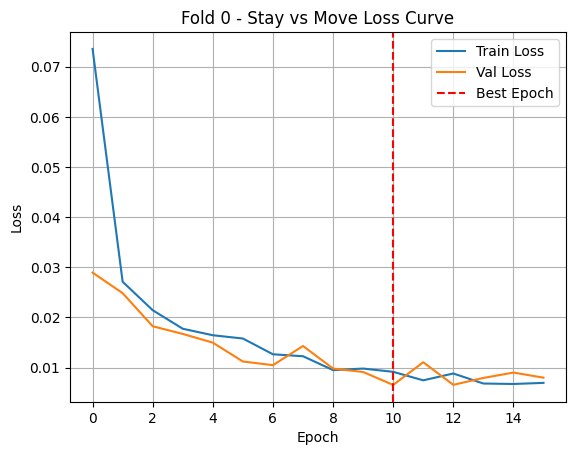

Confusion Matrix - Stay vs Move


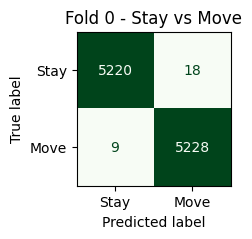

              precision    recall  f1-score   support

        Stay     0.9983    0.9966    0.9974      5238
        Move     0.9966    0.9983    0.9974      5237

    accuracy                         0.9974     10475
   macro avg     0.9974    0.9974    0.9974     10475
weighted avg     0.9974    0.9974    0.9974     10475


=== Fold 1 ===
Fold 1 - Stay vs Move | Epoch 000 | Train: 0.0794 | Val: 0.0303
Fold 1 - Stay vs Move | Epoch 001 | Train: 0.0281 | Val: 0.0216
Fold 1 - Stay vs Move | Epoch 002 | Train: 0.0228 | Val: 0.0211
Fold 1 - Stay vs Move | Epoch 003 | Train: 0.0211 | Val: 0.0210
Fold 1 - Stay vs Move | Epoch 004 | Train: 0.0163 | Val: 0.0153
Fold 1 - Stay vs Move | Epoch 005 | Train: 0.0149 | Val: 0.0138
Fold 1 - Stay vs Move | Epoch 006 | Train: 0.0140 | Val: 0.0197
Fold 1 - Stay vs Move | Epoch 007 | Train: 0.0122 | Val: 0.0117
Fold 1 - Stay vs Move | Epoch 008 | Train: 0.0120 | Val: 0.0115
Fold 1 - Stay vs Move | Epoch 009 | Train: 0.0097 | Val: 0.0103
Fold 1 - Stay vs 

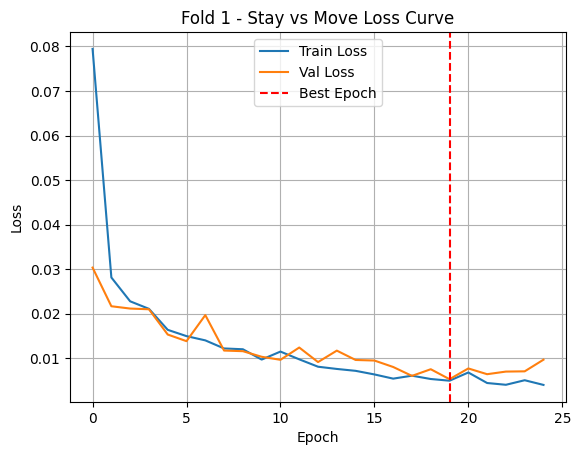

Confusion Matrix - Stay vs Move


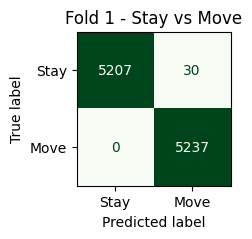

              precision    recall  f1-score   support

        Stay     1.0000    0.9943    0.9971      5237
        Move     0.9943    1.0000    0.9971      5237

    accuracy                         0.9971     10474
   macro avg     0.9972    0.9971    0.9971     10474
weighted avg     0.9972    0.9971    0.9971     10474


=== Fold 2 ===
Fold 2 - Stay vs Move | Epoch 000 | Train: 0.0865 | Val: 0.0288
Fold 2 - Stay vs Move | Epoch 001 | Train: 0.0294 | Val: 0.0215
Fold 2 - Stay vs Move | Epoch 002 | Train: 0.0222 | Val: 0.0174
Fold 2 - Stay vs Move | Epoch 003 | Train: 0.0191 | Val: 0.0167
Fold 2 - Stay vs Move | Epoch 004 | Train: 0.0161 | Val: 0.0134
Fold 2 - Stay vs Move | Epoch 005 | Train: 0.0149 | Val: 0.0169
Fold 2 - Stay vs Move | Epoch 006 | Train: 0.0130 | Val: 0.0133
Fold 2 - Stay vs Move | Epoch 007 | Train: 0.0121 | Val: 0.0113
Fold 2 - Stay vs Move | Epoch 008 | Train: 0.0105 | Val: 0.0103
Fold 2 - Stay vs Move | Epoch 009 | Train: 0.0101 | Val: 0.0094
Fold 2 - Stay vs 

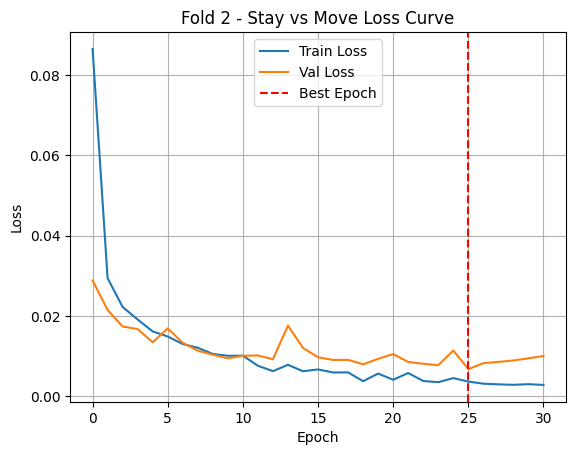

Confusion Matrix - Stay vs Move


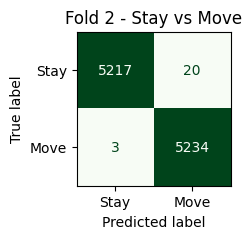

              precision    recall  f1-score   support

        Stay     0.9994    0.9962    0.9978      5237
        Move     0.9962    0.9994    0.9978      5237

    accuracy                         0.9978     10474
   macro avg     0.9978    0.9978    0.9978     10474
weighted avg     0.9978    0.9978    0.9978     10474


=== Fold 3 ===
Fold 3 - Stay vs Move | Epoch 000 | Train: 0.0824 | Val: 0.0249
Fold 3 - Stay vs Move | Epoch 001 | Train: 0.0287 | Val: 0.0203
Fold 3 - Stay vs Move | Epoch 002 | Train: 0.0237 | Val: 0.0167
Fold 3 - Stay vs Move | Epoch 003 | Train: 0.0194 | Val: 0.0115
Fold 3 - Stay vs Move | Epoch 004 | Train: 0.0186 | Val: 0.0108
Fold 3 - Stay vs Move | Epoch 005 | Train: 0.0143 | Val: 0.0127
Fold 3 - Stay vs Move | Epoch 006 | Train: 0.0150 | Val: 0.0104
Fold 3 - Stay vs Move | Epoch 007 | Train: 0.0121 | Val: 0.0081
Fold 3 - Stay vs Move | Epoch 008 | Train: 0.0124 | Val: 0.0094
Fold 3 - Stay vs Move | Epoch 009 | Train: 0.0110 | Val: 0.0076
Fold 3 - Stay vs 

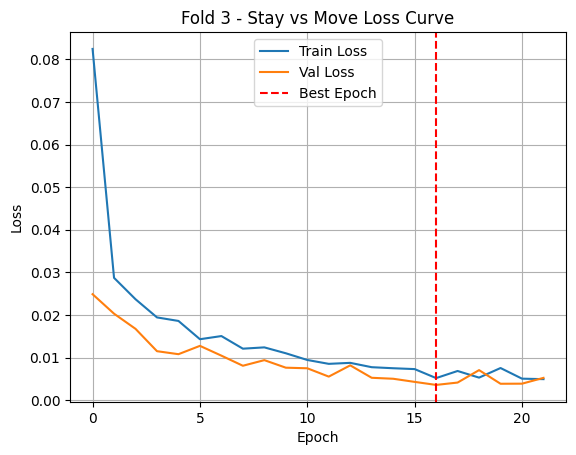

Confusion Matrix - Stay vs Move


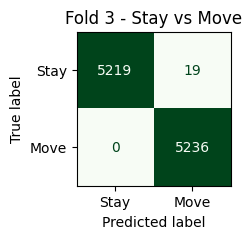

              precision    recall  f1-score   support

        Stay     1.0000    0.9964    0.9982      5238
        Move     0.9964    1.0000    0.9982      5236

    accuracy                         0.9982     10474
   macro avg     0.9982    0.9982    0.9982     10474
weighted avg     0.9982    0.9982    0.9982     10474


=== Fold 4 ===
Fold 4 - Stay vs Move | Epoch 000 | Train: 0.0804 | Val: 0.0250
Fold 4 - Stay vs Move | Epoch 001 | Train: 0.0288 | Val: 0.0205
Fold 4 - Stay vs Move | Epoch 002 | Train: 0.0228 | Val: 0.0198
Fold 4 - Stay vs Move | Epoch 003 | Train: 0.0197 | Val: 0.0177
Fold 4 - Stay vs Move | Epoch 004 | Train: 0.0176 | Val: 0.0164
Fold 4 - Stay vs Move | Epoch 005 | Train: 0.0144 | Val: 0.0132
Fold 4 - Stay vs Move | Epoch 006 | Train: 0.0135 | Val: 0.0114
Fold 4 - Stay vs Move | Epoch 007 | Train: 0.0120 | Val: 0.0105
Fold 4 - Stay vs Move | Epoch 008 | Train: 0.0106 | Val: 0.0148
Fold 4 - Stay vs Move | Epoch 009 | Train: 0.0121 | Val: 0.0096
Fold 4 - Stay vs 

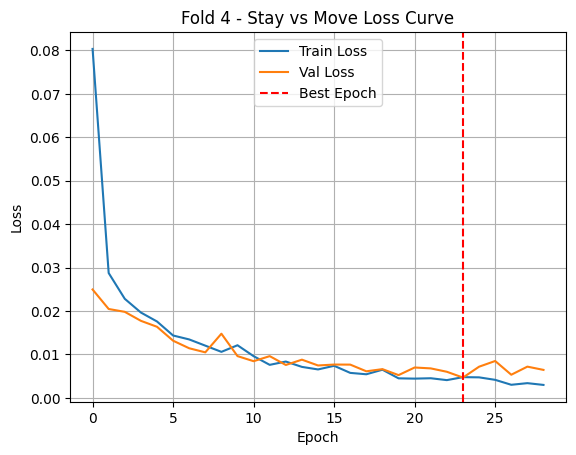

Confusion Matrix - Stay vs Move


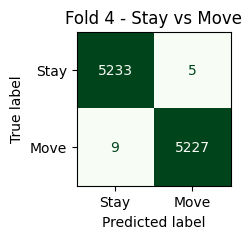

              precision    recall  f1-score   support

        Stay     0.9983    0.9990    0.9987      5238
        Move     0.9990    0.9983    0.9987      5236

    accuracy                         0.9987     10474
   macro avg     0.9987    0.9987    0.9987     10474
weighted avg     0.9987    0.9987    0.9987     10474



In [8]:
for fold_idx, (train_idx, test_idx) in enumerate(folds):
    print(f"\n=== Fold {fold_idx} ===")

    X_train_raw, y_train_raw = X_all[train_idx], y_all[train_idx]
    X_test_raw, y_test_raw = X_all[test_idx], y_all[test_idx]

    # STEP 1: Stay vs Move
    y_train_stay = np.array([0 if y == 'Stay' else 1 for y in y_train_raw])
    y_test_stay = np.array([0 if y == 'Stay' else 1 for y in y_test_raw])

    model_stay = train_binary_model(
        X_train_raw, y_train_stay,
        X_test_raw, y_test_stay,
        feature_dim=X_train_raw.shape[2],
        label_name=f"Fold {fold_idx} - Stay vs Move"
    )

    preds_stay = model_stay(torch.tensor(X_test_raw, dtype=torch.float32).to(device)).argmax(dim=1).cpu().numpy()
    print("Confusion Matrix - Stay vs Move")
    cm_stay = confusion_matrix(y_test_stay, preds_stay)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    disp = ConfusionMatrixDisplay(cm_stay, display_labels=["Stay", "Move"])
    disp.plot(ax=ax, cmap='Greens', values_format='d', colorbar=False)
    plt.title(f"Fold {fold_idx} - Stay vs Move")
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_test_stay, preds_stay, target_names=["Stay", "Move"], digits=4))